# ANAC


#### imports

In [148]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

#### set seed

In [149]:
seed = 2024
np.random.seed(seed)

#### read in data

In [150]:
diet_csv = pd.read_csv("diet.csv").copy()
recipes_csv = pd.read_csv("recipes.csv").copy()
requests_csv = pd.read_csv("requests.csv").copy()
reviews_csv = pd.read_csv("reviews.csv").copy()

C:\Users\Maximilian Mittmann\AppData\Local\Temp\ipykernel_10880\3884275055.py:4: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  reviews_csv = pd.read_csv("reviews.csv").copy()


In [151]:
diet_csv.info() # 271907 entries
requests_csv.info() # 140195 entries
recipes_csv.info() #75604 entries
reviews_csv.info() # 140195 entries
# --> not all customers gave a review!

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271907 entries, 0 to 271906
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   AuthorId  271907 non-null  object
 1   Diet      271906 non-null  object
 2   Age       271907 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 6.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140195 entries, 0 to 140194
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   AuthorId      140195 non-null  object 
 1   RecipeId      140195 non-null  int64  
 2   Time          140195 non-null  float64
 3   HighCalories  140195 non-null  float64
 4   HighProtein   140195 non-null  object 
 5   LowFat        140195 non-null  int64  
 6   LowSugar      140195 non-null  object 
 7   HighFiber     140195 non-null  int64  
dtypes: float64(2), int64(3), object(3)
memory usage: 8.6+ MB
<class 'pandas.core.frame.DataFra

### Data Cleaning
#### diet_csv

In [152]:
#rename column
diet_csv.rename(columns= {"AuthorId" : "CustomerId"}, inplace=True)
# Change type of Diet into category
diet_csv["Diet"] = diet_csv["Diet"].astype("category")


In [153]:
# delete row with missing value for diet
diet_csv = diet_csv.dropna(axis="rows")

In [154]:
diet_csv

,CustomerId,Diet,Age
0,10000120E,Vegetarian,46
1,1000014D,Vegan,18
2,1000015A,Vegetarian,58
3,1000016E,Vegetarian,32
4,1000027E,Vegan,61
...,...,...,...
271902,999917E,Vegetarian,28
271903,999936C,Omnivore,22
271904,99993D,Vegetarian,58
271905,99994A,Vegetarian,18


#### recipes_csv

In [155]:
# Change type for Recipe Category
recipes_csv["RecipeCategory"] = recipes_csv["RecipeCategory"].astype("category")


In [156]:
# Add new column TotalTimeNeeded
recipes_csv["TotalTimeNeeded"] = recipes_csv["CookTime"] + recipes_csv["PrepTime"]
recipes_csv

,RecipeId,Name,CookTime,PrepTime,RecipeCategory,RecipeIngredientQuantities,RecipeIngredientParts,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeYield,TotalTimeNeeded
0,73440,Bow Ties With Broccoli Pesto,0,1800,Other,"c(""\""6\"""", ""\""2\"""", ""\""1 1/2\"""", ""\""1/4\"""", ""\...","c(""\""hazelnuts\"""", ""\""broccoli florets\"""", ""\""...",241.3,10.1,1.2,0.0,13.1,31.8,2.3,1.4,6.7,9.0,NaN,1800
1,365718,Cashew-chutney Rice,3600,600,Other,"c(""\""1\"""", ""\""3/4\"""", ""\""6\"""", ""\""5\"""", ""\""2\""...","c(""\""celery\"""", ""\""onion\"""", ""\""butter\"""", ""\""...",370.8,17.5,7.2,22.9,553.3,44.3,1.6,2.2,9.4,8.0,NaN,4200
2,141757,Copycat Taco Bell Nacho Fries BellGrande,3600,2700,Other,"c(""\""3\"""", ""\""1/2\"""", ""\""1\"""", ""\""1\"""", ""\""3\""...","c(""\""Copycat Taco Bell Seasoned Beef\"""", ""\""ye...",377.6,20.9,10.5,45.7,1501.8,36.6,3.8,6.1,12.9,8.0,NaN,6300
3,280351,Slow Cooker Jalapeno Cheddar Cheese Soup,18000,1800,Other,"c(""\""2\"""", ""\""1\"""", ""\""2\"""", ""\""2\"""", ""\""1\"""",...","c(""\""unsalted butter\"""", ""\""yellow onion\"""", ""...",282.8,16.5,10.3,50.5,630.2,22.8,2.3,2.7,11.7,6.0,NaN,19800
4,180505,Cool & Crisp Citrus Chiffon Pie,3600,1800,Other,"c(""\""1\"""", ""\""1/4\"""", ""\""1/2\"""", ""\""1/2\"""", ""\...","c(""\""unflavored gelatin\"""", ""\""water\"""", ""\""su...",257.5,8.6,2.4,110.7,160.9,39.8,0.4,30.2,6.3,6.0,NaN,5400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75599,253577,Frijoles Negros- Crock Pot Mexican Black Beans,43200,28800,Other,"c(""\""2\"""", ""\""6 -8\"""", ""\""5\"""", ""\""1/2\"""", ""\""...","c(""\""black beans\"""", ""\""water\"""", ""\""bay leave...",121.5,0.5,0.1,0.0,1175.1,22.2,7.8,0.6,7.9,NaN,NaN,72000
75600,267827,Moose Moussaka,3600,2700,Other,"c(""\""1\"""", ""\""6\"""", ""\""2\"""", ""\""2\"""", ""\""1/2\""...","c(""\""onion\"""", ""\""garlic cloves\"""", ""\""olive o...",652.2,25.8,10.7,197.9,435.5,51.9,7.5,7.2,50.1,NaN,NaN,6300
75601,266983,Cantonese Pepper Steak for Two (Or More),1800,900,Other,"c(""\""1/2\"""", ""\""1\"""", ""\""1/8\"""", ""\""1/8\"""", ""\...","c(""\""top round steak\"""", ""\""cornstarch\"""", ""\""...",223.9,9.2,3.6,78.3,725.9,7.3,1.1,1.7,26.7,2.0,NaN,2700
75602,253739,Coconut Cream Cooler,300,120,Other,"c(""\""1\"""", ""\""1\"""", ""\""1\"""", ""\""7 1/2\"""", ""\""1...","c(""\""cream of coconut\"""", ""\""water\"""")",2229.8,80.3,69.3,0.0,294.7,369.0,15.7,317.9,26.7,NaN,1 gallon,420


In [157]:
#drop recipeservings and yields and saturated + cholesterol + sodium + carbohydratecontent for now
recipes_csv = recipes_csv.drop("RecipeServings", axis=1)
recipes_csv = recipes_csv.drop("RecipeYield", axis=1)
#recipes_csv = recipes_csv.drop("SaturatedFatContent", axis=1)
#recipes_csv = recipes_csv.drop("CholesterolContent", axis=1)
#recipes_csv = recipes_csv.drop("SodiumContent", axis=1)
#recipes_csv = recipes_csv.drop("CarbohydrateContent", axis=1)
#also drop cook n preptime n quantities n parts
recipes_csv = recipes_csv.drop("PrepTime", axis=1)
recipes_csv = recipes_csv.drop("CookTime", axis=1)
recipes_csv = recipes_csv.drop("RecipeIngredientQuantities", axis=1)
recipes_csv = recipes_csv.drop("RecipeIngredientParts", axis=1)

C:\Users\Maximilian Mittmann\AppData\Local\Temp\ipykernel_10880\4017132431.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  recipes_csv.groupby("RecipeCategory").count()


,RecipeId,Name,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,TotalTimeNeeded
RecipeCategory,,,,,,,,,,,,
Beverages,2303,2303,2303,2303,2303,2303,2303,2303,2303,2303,2303,2303
Bread,4246,4246,4246,4246,4246,4246,4246,4246,4246,4246,4246,4246
Breakfast,3033,3033,3033,3033,3033,3033,3033,3033,3033,3033,3033,3033
Lunch,4887,4887,4887,4887,4887,4887,4887,4887,4887,4887,4887,4887
One dish meal,4590,4590,4590,4590,4590,4590,4590,4590,4590,4590,4590,4590
Other,56347,56347,56347,56347,56347,56347,56347,56347,56347,56347,56347,56347
Soup,198,198,198,198,198,198,198,198,198,198,198,198


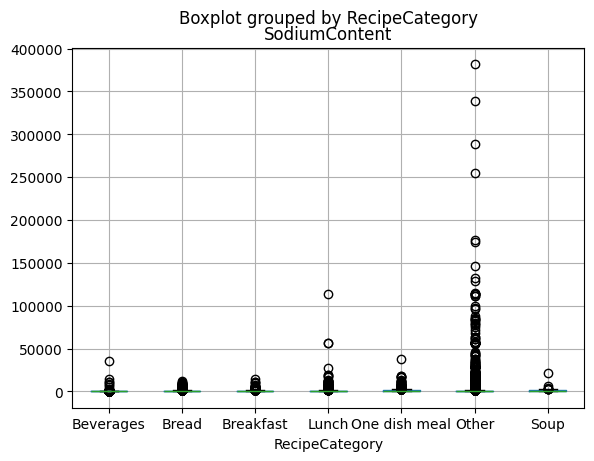

In [194]:
# Handle outliers (max values like 300000 for sodium content
recipes_csv.boxplot(column=["SodiumContent"], by="RecipeCategory")
recipes_csv.groupby("RecipeCategory").count()


In [ ]:
high_sodium = recipes_csv[recipes_csv["SodiumContent"] > 4000]
print(high_sodium['SodiumContent'].mean())
print(recipes_csv["SodiumContent"].mean())
normal_sodium = recipes_csv[(recipes_csv["SodiumContent"] <= 4000)]
print(normal_sodium["SodiumContent"].max())
normal_sodium_mean = normal_sodium["SodiumContent"].mean()
normal_sodium_mean

In [159]:
recipes_csv

,RecipeId,Name,RecipeCategory,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,TotalTimeNeeded
0,73440,Bow Ties With Broccoli Pesto,Other,241.3,10.1,1.2,0.0,13.1,31.8,2.3,1.4,6.7,1800
1,365718,Cashew-chutney Rice,Other,370.8,17.5,7.2,22.9,553.3,44.3,1.6,2.2,9.4,4200
2,141757,Copycat Taco Bell Nacho Fries BellGrande,Other,377.6,20.9,10.5,45.7,1501.8,36.6,3.8,6.1,12.9,6300
3,280351,Slow Cooker Jalapeno Cheddar Cheese Soup,Other,282.8,16.5,10.3,50.5,630.2,22.8,2.3,2.7,11.7,19800
4,180505,Cool & Crisp Citrus Chiffon Pie,Other,257.5,8.6,2.4,110.7,160.9,39.8,0.4,30.2,6.3,5400
...,...,...,...,...,...,...,...,...,...,...,...,...,...
75599,253577,Frijoles Negros- Crock Pot Mexican Black Beans,Other,121.5,0.5,0.1,0.0,1175.1,22.2,7.8,0.6,7.9,72000
75600,267827,Moose Moussaka,Other,652.2,25.8,10.7,197.9,435.5,51.9,7.5,7.2,50.1,6300
75601,266983,Cantonese Pepper Steak for Two (Or More),Other,223.9,9.2,3.6,78.3,725.9,7.3,1.1,1.7,26.7,2700
75602,253739,Coconut Cream Cooler,Other,2229.8,80.3,69.3,0.0,294.7,369.0,15.7,317.9,26.7,420


##### requests_csv

In [160]:
requests_csv

,AuthorId,RecipeId,Time,HighCalories,HighProtein,LowFat,LowSugar,HighFiber
0,2001012259B,73440,1799.950949,0.0,Indifferent,0,0,0
1,437641B,365718,4201.820980,0.0,Yes,0,Indifferent,1
2,1803340263D,141757,6299.861496,0.0,Indifferent,1,Indifferent,0
3,854048B,280351,19801.365796,0.0,Yes,1,0,1
4,2277685E,180505,5400.093457,0.0,Indifferent,0,0,0
...,...,...,...,...,...,...,...,...
140190,163793B,78171,1560.649725,0.0,Indifferent,0,0,1
140191,33888B,333262,1502.011466,1.0,Indifferent,1,0,0
140192,401942C,49200,5999.274269,0.0,Indifferent,0,0,1
140193,346866B,214815,899.523513,0.0,Yes,1,Indifferent,1


In [161]:
#rename column
requests_csv.rename(columns= {"AuthorId" : "CustomerId"}, inplace=True)
# Map indifferent values for HighProtein and LowSugar
requests_csv["HighProtein"] = requests_csv["HighProtein"].map({
    "Indifferent": 0,
    "0": 0,
    "1": 1,
    "Yes": 1
})

requests_csv["LowSugar"] = requests_csv["LowSugar"].map({
    "Indifferent": 0,
    "0": 0,
    "1": 1
})


In [162]:
# Change types to boolean
requests_csv["HighCalories"] = requests_csv["HighCalories"].astype("bool")
requests_csv["LowFat"] = requests_csv["LowFat"].astype("bool")
requests_csv["HighFiber"] = requests_csv["HighFiber"].astype("bool")
requests_csv["HighProtein"] = requests_csv["HighProtein"].astype("bool")
requests_csv["LowSugar"] = requests_csv["LowSugar"].astype("bool")

In [163]:
# Replace negative time requests with 0 and round time values to int
requests_csv['Time'] = np.where(requests_csv['Time'] < 0, 0, requests_csv['Time'])
requests_csv['Time'] = requests_csv['Time'].round().astype('int')
requests_csv.rename(columns={'Time':'RequestedTime'}, inplace=True)

In [164]:
requests_csv

,CustomerId,RecipeId,RequestedTime,HighCalories,HighProtein,LowFat,LowSugar,HighFiber
0,2001012259B,73440,1800,False,False,False,False,False
1,437641B,365718,4202,False,True,False,False,True
2,1803340263D,141757,6300,False,False,True,False,False
3,854048B,280351,19801,False,True,True,False,True
4,2277685E,180505,5400,False,False,False,False,False
...,...,...,...,...,...,...,...,...
140190,163793B,78171,1561,False,False,False,False,True
140191,33888B,333262,1502,True,False,True,False,False
140192,401942C,49200,5999,False,False,False,False,True
140193,346866B,214815,900,False,True,True,False,True


#### reviews_csv

In [165]:

# TODO why are there missing values for TestSetId? 

In [166]:
# Rename column
reviews_csv.rename(columns= {"AuthorId" : "CustomerId"}, inplace=True)
# Remove NA rows and Rating column and TestSetId
reviews_csv = reviews_csv.drop("Rating", axis=1)
reviews_csv.dropna(subset=["Like"], inplace=True) # note: now the entries are reduced to 97381 entries
reviews_csv = reviews_csv.drop("TestSetId", axis=1)

In [167]:
# convert Like type to boolean
reviews_csv["Like"] = reviews_csv["Like"].astype("boolean")

In [168]:
reviews_csv

,CustomerId,RecipeId,Like
42814,1000036C,320576,False
42815,1000216B,189335,False
42816,1000221A,133043,False
42817,1000221A,90537,False
42818,1000221A,334314,False
...,...,...,...
140190,999595E,338070,False
140191,999774A,29002,False
140192,999774A,159252,False
140193,999774A,1171,True


#### Join the tables

In [169]:
requests_csv

,CustomerId,RecipeId,RequestedTime,HighCalories,HighProtein,LowFat,LowSugar,HighFiber
0,2001012259B,73440,1800,False,False,False,False,False
1,437641B,365718,4202,False,True,False,False,True
2,1803340263D,141757,6300,False,False,True,False,False
3,854048B,280351,19801,False,True,True,False,True
4,2277685E,180505,5400,False,False,False,False,False
...,...,...,...,...,...,...,...,...
140190,163793B,78171,1561,False,False,False,False,True
140191,33888B,333262,1502,True,False,True,False,False
140192,401942C,49200,5999,False,False,False,False,True
140193,346866B,214815,900,False,True,True,False,True


In [170]:
# merge diet + request
request_with_diet = pd.merge(diet_csv, requests_csv, how="inner", on="CustomerId")
request_with_diet

,CustomerId,Diet,Age,RecipeId,RequestedTime,HighCalories,HighProtein,LowFat,LowSugar,HighFiber
0,1000036C,Vegetarian,50,320576,119,False,False,False,False,True
1,1000216B,Vegetarian,78,189335,1199,False,True,False,False,True
2,1000221A,Vegetarian,25,133043,362,False,True,False,False,True
3,1000221A,Vegetarian,25,90537,1199,False,True,False,False,True
4,1000221A,Vegetarian,25,334314,5400,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...
140190,999774A,Vegetarian,57,29002,2402,False,False,False,False,False
140191,999774A,Vegetarian,57,159252,6000,False,True,False,False,False
140192,999774A,Vegetarian,57,1171,480,True,True,False,False,False
140193,999917E,Vegetarian,28,169413,3600,False,False,False,False,False


In [171]:
# merge diet + request + recipe
request_with_diet_and_recipe = pd.merge(recipes_csv, request_with_diet, how="inner", on="RecipeId")
request_with_diet_and_recipe

,RecipeId,Name,RecipeCategory,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,...,TotalTimeNeeded,CustomerId,Diet,Age,RequestedTime,HighCalories,HighProtein,LowFat,LowSugar,HighFiber
0,73440,Bow Ties With Broccoli Pesto,Other,241.3,10.1,1.2,0.0,13.1,31.8,2.3,...,1800,1073154D,Vegetarian,59,1800,False,False,True,False,True
1,73440,Bow Ties With Broccoli Pesto,Other,241.3,10.1,1.2,0.0,13.1,31.8,2.3,...,1800,1134684A,Vegan,70,1799,False,False,False,False,False
2,73440,Bow Ties With Broccoli Pesto,Other,241.3,10.1,1.2,0.0,13.1,31.8,2.3,...,1800,120376D,Vegetarian,21,1799,False,True,False,False,False
3,73440,Bow Ties With Broccoli Pesto,Other,241.3,10.1,1.2,0.0,13.1,31.8,2.3,...,1800,1208183D,Vegan,65,1801,True,False,False,False,False
4,73440,Bow Ties With Broccoli Pesto,Other,241.3,10.1,1.2,0.0,13.1,31.8,2.3,...,1800,1302995D,Vegan,65,1800,True,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140190,253577,Frijoles Negros- Crock Pot Mexican Black Beans,Other,121.5,0.5,0.1,0.0,1175.1,22.2,7.8,...,72000,1677720D,Vegan,27,71999,False,False,True,False,True
140191,267827,Moose Moussaka,Other,652.2,25.8,10.7,197.9,435.5,51.9,7.5,...,6300,853126B,Vegetarian,63,6299,False,True,True,False,False
140192,266983,Cantonese Pepper Steak for Two (Or More),Other,223.9,9.2,3.6,78.3,725.9,7.3,1.1,...,2700,2000154789A,Omnivore,78,2701,False,True,False,False,True
140193,253739,Coconut Cream Cooler,Other,2229.8,80.3,69.3,0.0,294.7,369.0,15.7,...,420,499207A,Vegetarian,19,420,True,False,False,False,False


In [172]:
# merge diet + request + recipe + review
request_with_diet_recipe_and_review = pd.merge(reviews_csv, request_with_diet_and_recipe, how="inner", on=["CustomerId", "RecipeId"])
# add Column for the difference between RequestedTime and TotalTimeNeeded
request_with_diet_recipe_and_review["TimeDifference"] = request_with_diet_recipe_and_review['RequestedTime'] - request_with_diet_recipe_and_review['TotalTimeNeeded']

request_with_diet_recipe_and_review

,CustomerId,RecipeId,Like,Name,RecipeCategory,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,...,TotalTimeNeeded,Diet,Age,RequestedTime,HighCalories,HighProtein,LowFat,LowSugar,HighFiber,TimeDifference
0,1000036C,320576,False,Downeaster,Beverages,138.7,0.0,0.0,0.0,0.6,...,120,Vegetarian,50,119,False,False,False,False,True,-1
1,1000216B,189335,False,Thai Rice Soup (Kao Tome Gai),Other,395.7,19.2,4.5,33.9,714.2,...,1200,Vegetarian,78,1199,False,True,False,False,True,-1
2,1000221A,133043,False,Lemon and Thyme Marinade for Poultry,Other,125.6,13.5,1.9,0.0,0.6,...,360,Vegetarian,25,362,False,True,False,False,True,2
3,1000221A,90537,False,Black Bean Salsa,Breakfast,1590.1,49.0,7.2,0.0,115.8,...,1200,Vegetarian,25,1199,False,True,False,False,True,-1
4,1000221A,334314,False,Irish Soda Bread,Bread,770.9,11.0,3.1,110.0,1033.0,...,5400,Vegetarian,25,5400,True,False,False,False,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97376,999595E,338070,False,Pumpkin Cake Mix Dessert,Other,464.3,31.4,15.0,99.8,391.7,...,3900,Vegetarian,31,3899,False,False,True,False,False,-1
97377,999774A,29002,False,Summer Corkscrew Pasta,Other,838.5,33.3,8.5,33.2,318.2,...,2400,Vegetarian,57,2402,False,False,False,False,False,2
97378,999774A,159252,False,"Chili, Kaffir Lime and Lemongrass Jelly",Other,928.0,0.6,0.1,0.0,6.8,...,6000,Vegetarian,57,6000,False,True,False,False,False,0
97379,999774A,1171,True,Kahlua Hot Chocolate,Beverages,665.9,19.8,12.2,68.3,247.4,...,480,Vegetarian,57,480,True,True,False,False,False,0


In [173]:
# One hot encoding for categorical variables
df = pd.get_dummies(request_with_diet_recipe_and_review, columns=["Diet", "RecipeCategory"], drop_first=True)

In [174]:
# Split dataset into train and test df
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.20, stratify=request_with_diet_recipe_and_review['Like'], random_state=seed)

In [175]:
request_with_diet_recipe_and_review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97381 entries, 0 to 97380
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   CustomerId           97381 non-null  object  
 1   RecipeId             97381 non-null  int64   
 2   Like                 97381 non-null  boolean 
 3   Name                 97381 non-null  object  
 4   RecipeCategory       97381 non-null  category
 5   Calories             97381 non-null  float64 
 6   FatContent           97381 non-null  float64 
 7   SaturatedFatContent  97381 non-null  float64 
 8   CholesterolContent   97381 non-null  float64 
 9   SodiumContent        97381 non-null  float64 
 10  CarbohydrateContent  97381 non-null  float64 
 11  FiberContent         97381 non-null  float64 
 12  SugarContent         97381 non-null  float64 
 13  ProteinContent       97381 non-null  float64 
 14  TotalTimeNeeded      97381 non-null  int64   
 15  Diet               

***Train Model***


In [180]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score
                                              
train_model = RandomForestClassifier(n_estimators=10, max_features=4, random_state=2024)

X = train_df.drop(columns=["Like", "CustomerId", "RecipeId", "Name"])
y = train_df["Like"]

train_model.fit(X,y)

# Calculate balanced accuracy
pred = train_model.predict(X)
score = np.mean(cross_val_score(train_model, X, y, cv=4, scoring="balanced_accuracy"))
print("Cross validation score for balanced accuracy: " + str(score))

# Report scores on model
y_pred = train_model.predict(X)
print("Precision:", precision_score(y, y_pred))
print("Accuracy:", accuracy_score(y, y_pred))
print("Recall:", recall_score(y, y_pred))
print("Balanced Accuracy", balanced_accuracy_score(y, y_pred))


Cross validation score for balanced accuracy: 0.6145947754627257
Precision: 0.9977864446084115
Accuracy: 0.988999281166564
Recall: 0.9188507086002717
Balanced Accuracy 0.9592700334516402


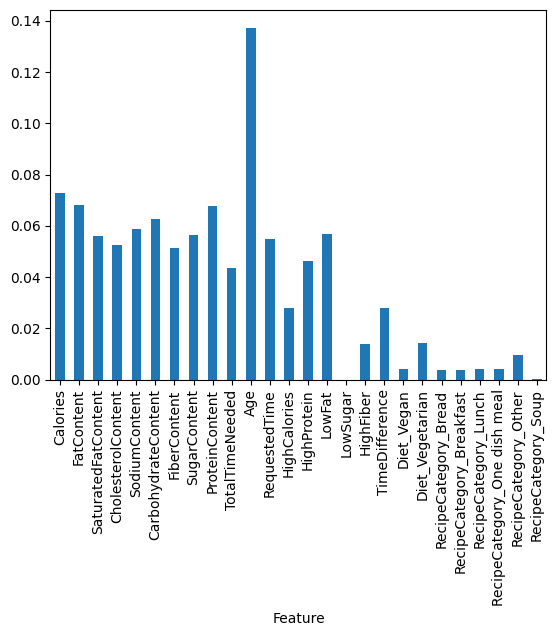

In [177]:
# Plot feature importance 

importance_values = train_model.feature_importances_
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importance_values})
imp_plot = importance_df.plot(kind='bar', x='Feature', y='Importance', legend=False)
imp_plot.plot()
plt.show()

***Test Model***

In [178]:
test_df = test_df.drop(columns=["CustomerId", "RecipeId", "Name"])

In [179]:
test_predictions = train_model.predict(test_df.drop(columns=['Like']))
test_probabilities = train_model.predict_proba(test_df.drop(columns=['Like']))

test_predictions_df = pd.DataFrame({'Like': test_df['Like'], 
                                     'Predicted_Like': test_predictions,
                                     'Probability_Like=0': test_probabilities[:, 0],
                                     'Probability_Like=1': test_probabilities[:, 1]})
print(test_predictions_df)


# Confusion Matrix
conf_matrix = confusion_matrix(test_df['Like'], test_predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Precision, accuracy, recall
print("Test-Precision:", precision_score(test_df['Like'], test_predictions))
print("Test-Accuracy:", accuracy_score(test_df['Like'], test_predictions))
print("Test-Recall:", recall_score(test_df['Like'], test_predictions))
print("Test Balanced Accuracy:", balanced_accuracy_score(test_df["Like"], test_predictions))

        Like  Predicted_Like  Probability_Like=0  Probability_Like=1
25046  False             0.0                 0.8                 0.2
40124   True             0.0                 0.6                 0.4
49430  False             0.0                 1.0                 0.0
71939  False             0.0                 1.0                 0.0
630    False             0.0                 1.0                 0.0
...      ...             ...                 ...                 ...
91766  False             0.0                 1.0                 0.0
27153  False             0.0                 1.0                 0.0
51545  False             0.0                 1.0                 0.0
25071  False             0.0                 0.8                 0.2
59952  False             0.0                 1.0                 0.0

[19477 rows x 4 columns]
Confusion Matrix:
[[16173   728]
 [ 1668   908]]
Test-Precision: 0.5550122249388753
Test-Accuracy: 0.8769831082815629
Test-Recall: 0.3524844720496


#### 1. Logistic Regression
#### 2. Decision Trees
#### 3. Random Forest
#### 4. Naive bayes
#### 5. Gradient Boosting

#### 1. Data Cleaning (missing values, merge tables)
#### 2. Set dataset into training & testing sets + download testing set
#### 3. modeling
#### 4. Model training: train model on training dataset
#### 5. Model evaluation (performance)
#### 6. prediction on the unseen data